## Import Libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    StratifiedKFold,
    GridSearchCV,
    cross_val_score
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)
from sklearn.neural_network import MLPClassifier

warnings.filterwarnings("ignore")

## Data Analysis

In [5]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("DATA SHAPE AND STRUCTURE")
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"Train columns: {train.columns.tolist()}")
print(f"Test columns: {test.columns.tolist()}")


DATA SHAPE AND STRUCTURE
Train shape: (5693, 6)
Test shape: (1424, 5)
Train columns: ['id', 'App Version Code', 'App Version Name', 'Review Text', 'Review Title', 'Star Rating']
Test columns: ['id', 'App Version Code', 'App Version Name', 'Review Text', 'Review Title']


In [6]:
print("MISSING VALUES ANALYSIS")

print("Train Dataset Missing Values:")
train_missing = pd.DataFrame({
    "Column": train.columns,
    "Missing_Count": train.isnull().sum().values,
    "Missing_Percentage": (train.isnull().sum() / len(train) * 100).round(2).values
})
print(train_missing)
print()
print("Test Dataset Missing Values:")
test_missing = pd.DataFrame({
    "Column": test.columns,
    "Missing_Count": test.isnull().sum().values,
    "Missing_Percentage": (test.isnull().sum() / len(test) * 100).round(2).values
})
print(test_missing)

MISSING VALUES ANALYSIS
Train Dataset Missing Values:
             Column  Missing_Count  Missing_Percentage
0                id              0                0.00
1  App Version Code           1139               20.01
2  App Version Name           1139               20.01
3       Review Text              1                0.02
4      Review Title           5091               89.43
5       Star Rating              0                0.00

Test Dataset Missing Values:
             Column  Missing_Count  Missing_Percentage
0                id              0                0.00
1  App Version Code            273               19.17
2  App Version Name            273               19.17
3       Review Text              1                0.07
4      Review Title           1244               87.36


In [7]:
print("CLASS IMBALANCE:")
for rating in sorted(train["Star Rating"].unique()):
    count = (train["Star Rating"] == rating).sum()
    pct = count / len(train) * 100
    print(f"Rating {rating}: {count} samples ({pct:.2f}%)")

CLASS IMBALANCE:
Rating 1: 1788 samples (31.41%)
Rating 2: 154 samples (2.71%)
Rating 3: 217 samples (3.81%)
Rating 4: 611 samples (10.73%)
Rating 5: 2923 samples (51.34%)


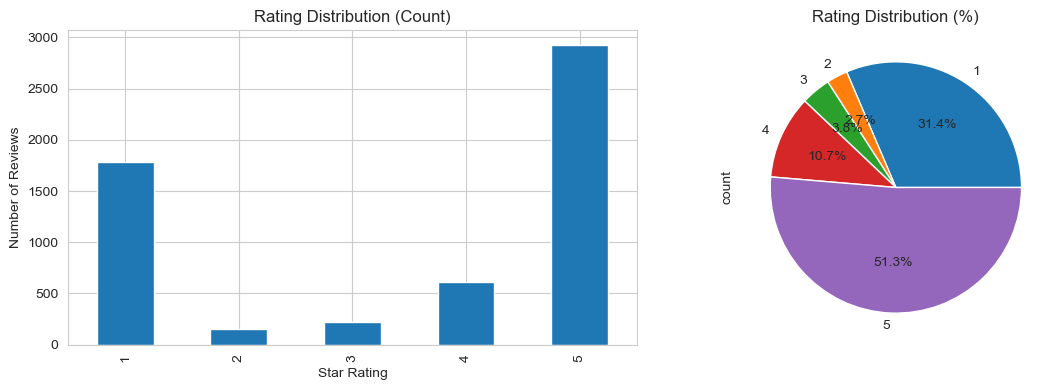

In [8]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar chart
train["Star Rating"].value_counts().sort_index().plot(
    kind="bar", ax=axes[0]
)
axes[0].set_title("Rating Distribution (Count)")
axes[0].set_xlabel("Star Rating")
axes[0].set_ylabel("Number of Reviews")

# Pie chart
train["Star Rating"].value_counts().sort_index().plot(
    kind="pie", ax=axes[1], autopct="%1.1f%%"
)
axes[1].set_title("Rating Distribution (%)")

plt.tight_layout()
plt.show()


## Data Preprocessing

In [16]:
nltk.download("wordnet", quiet=True)
nltk.download("stopwords", quiet=True)
y_train = train["Star Rating"].values

In [28]:
class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words("english"))

    def preprocess(self, text):
        if pd.isna(text):
            return ""
        text = text.lower()

        # Remove special characters & numbers
        text = re.sub(r"[^a-zA-Z\s]", "", text)

        # Remove extra spaces
        text = re.sub(r"\s+", " ", text).strip()

        # Tokenize (simple & safe)
        tokens = text.split()

        # Remove stopwords + lemmatize
        tokens = [
            self.lemmatizer.lemmatize(token)
            for token in tokens
            if token not in self.stop_words
        ]

        return " ".join(tokens)

# Initialize preprocessor
processor = TextPreprocessor()

train["title_proc"] = train["Review Title"].apply(processor.preprocess)
train["text_proc"] = train["Review Text"].apply(processor.preprocess)

test["title_proc"] = test["Review Title"].apply(processor.preprocess)
test["text_proc"] = test["Review Text"].apply(processor.preprocess)

train["combined_text"] = train["title_proc"] + " " + train["text_proc"]
test["combined_text"] = test["title_proc"] + " " + test["text_proc"]

#TF-IDF
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.9
)

X_train = tfidf.fit_transform(train["combined_text"])
X_test = tfidf.transform(test["combined_text"])

print("Training features shape:", X_train.shape)
print("Test features shape:", X_test.shape)
print("Labels shape:", y_train.shape)


Training features shape: (5693, 5000)
Test features shape: (1424, 5000)
Labels shape: (5693,)


## Training

In [29]:
INNER_CV = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
OUTER_CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

SCORING = "f1_weighted"


def evaluate(y_true, y_pred, name):
    acc = accuracy_score(y_true, y_pred)
    f1_w = f1_score(y_true, y_pred, average="weighted", zero_division=0)
    f1_m = f1_score(y_true, y_pred, average="macro", zero_division=0)

    print(f"\n{name}")
    print("-" * 60)
    print(f"Accuracy     : {acc:.4f}")
    print(f"Weighted F1  : {f1_w:.4f}")
    print(f"Macro F1     : {f1_m:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4, zero_division=0))
    print("-" * 60)
    return acc, f1_w, f1_m



def train_model(base_model, param_grid, name):
    print()
    print(f"Hyperparameter tuning: {name}")

    grid = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        scoring=SCORING,
        cv=INNER_CV,
        n_jobs=-1,
        verbose=0
    )

    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    print(f"Best Params: {grid.best_params_}")
    print(f"Best CV F1 : {grid.best_score_:.4f}")

    # Train on full training data
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_train)

    acc, f1_w, f1_m = evaluate(y_train, y_pred, name)
    plot_cm(y_train, y_pred, name)

    # -------- OUTER CV (Internal Validation) --------
    outer_scores = cross_val_score(
        best_model,
        X_train,
        y_train,
        cv=OUTER_CV,
        scoring=SCORING,
        n_jobs=-1
    )

    print(
        f"Outer CV Weighted F1: "
        f"{outer_scores.mean():.4f} ± {outer_scores.std():.4f}"
    )

    joblib.dump(
        best_model,
        f"model_{name.lower().replace(' ', '_')}.joblib"
    )

    return acc, f1_w, f1_m, outer_scores.mean()


In [30]:
def plot_cm(y_true, y_pred, name):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues"
    )
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(
        f"confusion_matrix_{name.lower().replace(' ', '_')}.png",
        dpi=300
    )
    plt.close()

#### Models for training

In [31]:
models = {
    "Logistic Regression": (
        LogisticRegression(
            max_iter=2000,
            class_weight="balanced",
            solver="lbfgs",
            n_jobs=-1,
            random_state=42
        ),
        {
            "C": [0.01, 0.1, 1, 10]
        }
    ),

    "Random Forest": (
        RandomForestClassifier(
            class_weight="balanced",
            random_state=42,
            n_jobs=-1
        ),
        {
            "n_estimators": [100, 200],
            "max_depth": [10, 15, None],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2],
            "max_features": ["sqrt", "log2"]
        }
    )
}

#### Training and training results

In [32]:
results = []

for name, (model, grid) in models.items():
    acc, f1_w, f1_m, cv_f1 = train_model(model, grid, name)
    results.append([name, acc, f1_w, f1_m, cv_f1])


Hyperparameter tuning: Logistic Regression
Best Params: {'C': 10}
Best CV F1 : 0.6569

Logistic Regression
------------------------------------------------------------
Accuracy     : 0.8563
Weighted F1  : 0.8655
Macro F1     : 0.8186

Classification Report:
              precision    recall  f1-score   support

           1     0.9751    0.9653    0.9702      1788
           2     0.8393    0.9156    0.8758       154
           3     0.7203    0.8664    0.7866       217
           4     0.4838    0.7823    0.5979       611
           5     0.9346    0.8012    0.8628      2923

    accuracy                         0.8563      5693
   macro avg     0.7906    0.8662    0.8186      5693
weighted avg     0.8882    0.8563    0.8655      5693

------------------------------------------------------------
Outer CV Weighted F1: 0.6606 ± 0.0064

Hyperparameter tuning: Random Forest
Best Params: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimato

In [33]:
comparison = pd.DataFrame(
    results,
    columns=[
        "Model",
        "Accuracy",
        "Weighted F1",
        "Macro F1",
        "Outer CV Weighted F1"
    ]
)

print(comparison.to_string(index=False))

best_idx = comparison["Outer CV Weighted F1"].idxmax()
print(
    f"BEST MODEL: {comparison.loc[best_idx, 'Model']}"
)
print(
    f"Outer CV Weighted F1: "
    f"{comparison.loc[best_idx, 'Outer CV Weighted F1']:.4f}"
)

comparison.to_csv("model_comparison_tuned.csv", index=False)
print("Saved: model_comparison_tuned.csv")


              Model  Accuracy  Weighted F1  Macro F1  Outer CV Weighted F1
Logistic Regression  0.856315     0.865534  0.818649              0.660603
      Random Forest  0.750922     0.765996  0.679939              0.674460
BEST MODEL: Random Forest
Outer CV Weighted F1: 0.6745
Saved: model_comparison_tuned.csv


## Prediction

In [34]:
import joblib

best_model = joblib.load("model_random_forest.joblib")

y_pred_test = best_model.predict(X_test)

submission = pd.DataFrame({
    "id": test["id"].values,
    "Star Rating": y_pred_test
})

# Save to CSV
submission.to_csv("predictions.csv", index=False)
print("saved: predictions.csv")

saved: predictions.csv
